In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Optional explainability libraries (graceful import)
HAS_LIME = True
HAS_SHAP = True
HAS_ELI5 = True

try:
    from lime.lime_text import LimeTextExplainer
except Exception as e:
    HAS_LIME = False
    print("LIME not available:", e)

try:
    import shap
except Exception as e:
    HAS_SHAP = False
    print("SHAP not available:", e)

try:
    import eli5
    from eli5.sklearn import explain_weights_sklearn
except Exception as e:
    HAS_ELI5 = False
    print("ELI5 not available:", e)

RANDOM_STATE = 42


In [30]:
# UCI Sentiment Labelled Sentences loader (IMDb text file)
# Uses the uploaded text file directly (provided in this chat).

from pathlib import Path
import re
import pandas as pd

UPLOADED_IMDB_TXT_PATH = "/content/imdb_labelled.txt"

def load_uci_imdb_labelled_from_txt(txt_path, verbose=True):
    """
    Load the UCI IMDb labelled sentences text file.
    Each line ends with a binary label and is typically formatted as:
        <sentence>\t<label>
    Some sentences may themselves contain tabs, so we split on the FINAL tab.
    """
    txt_path = Path(txt_path)
    if not txt_path.exists():
        raise FileNotFoundError(f"Dataset file not found: {txt_path}")

    rows = []
    skipped = 0

    with open(txt_path, "r", encoding="utf-8", errors="replace") as f:
        for line_num, raw_line in enumerate(f, start=1):
            line = raw_line.rstrip("\n\r")
            if not line.strip():
                continue

            # Robust parsing: split only on the last tab because the sentence may contain tabs.
            if "\t" in line:
                text, label_str = line.rsplit("\t", 1)
            else:
                # Fallback: last token is label (0/1)
                m = re.match(r"^(.*?)[ \t]+([01])\s*$", line)
                if not m:
                    skipped += 1
                    continue
                text, label_str = m.group(1), m.group(2)

            text = re.sub(r"\s+", " ", str(text)).strip()
            label_str = str(label_str).strip()

            if not text or label_str not in {"0", "1"}:
                skipped += 1
                continue

            rows.append((text, int(label_str)))

    df = pd.DataFrame(rows, columns=["text", "label"])
    df["source"] = "imdb"
    df = df.reset_index(drop=True)

    if verbose:
        print(f"Loaded IMDb file: {txt_path}")
        print(f"Rows: {len(df)}")
        print("Class counts:")
        print(df["label"].value_counts().sort_index())
        if skipped:
            print(f"Skipped malformed rows: {skipped}")

    if df.empty:
        raise ValueError("No valid rows were loaded from the IMDb labelled text file.")

    return df

# Load the uploaded IMDb labelled dataset
df = load_uci_imdb_labelled_from_txt(UPLOADED_IMDB_TXT_PATH, verbose=True)

print("Loaded shape:", df.shape)
print("Class counts:\n", df["label"].value_counts().sort_index())
print("Source counts:\n", df["source"].value_counts())
df.head()

Loaded IMDb file: /content/imdb_labelled.txt
Rows: 1000
Class counts:
label
0    500
1    500
Name: count, dtype: int64
Loaded shape: (1000, 3)
Class counts:
 label
0    500
1    500
Name: count, dtype: int64
Source counts:
 source
imdb    1000
Name: count, dtype: int64


,text,label,source
0,"A very, very, very slow-moving, aimless movie ...",0,imdb
1,Not sure who was more lost - the flat characte...,0,imdb
2,Attempting artiness with black & white and cle...,0,imdb
3,Very little music or anything to speak of.,0,imdb
4,The best scene in the movie was when Gerardo i...,1,imdb


              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       100
    positive       0.80      0.82      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



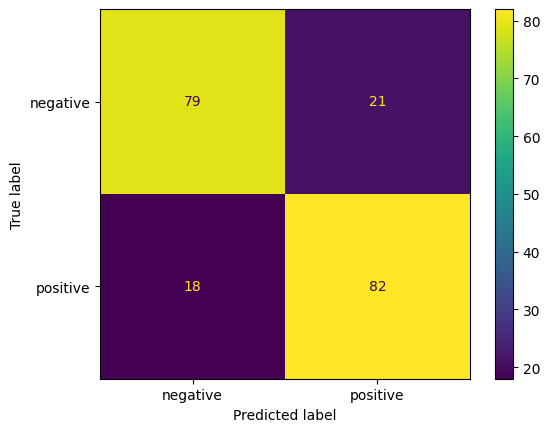

In [31]:

# Train/test split and model training on UCI IMDb sentences
X = df["text"].astype(str).tolist()
y = df["label"].astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=1)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot()
plt.show()


In [32]:

# Common helpers
class_names = ["negative", "positive"]
print("Class labels:", {0: "negative", 1: "positive"})

def predict_and_show(text):
    probs = pipeline.predict_proba([text])[0]
    pred = int(pipeline.predict([text])[0])
    print("Text:", text)
    print("Predicted class:", class_names[pred], f"({pred})")
    print("Probabilities:", {class_names[i]: round(float(p), 4) for i, p in enumerate(probs)})
    return pred, probs

sample_text = "This movie was amazing, great performances and beautiful direction!"
predict_and_show(sample_text)


Class labels: {0: 'negative', 1: 'positive'}
Text: This movie was amazing, great performances and beautiful direction!
Predicted class: positive (1)
Probabilities: {'negative': 0.2933, 'positive': 0.7067}


(1, array([0.29327137, 0.70672863]))

LIME explanation for predicted class: positive
[(np.str_('great'), 0.15817491410746562), (np.str_('direction'), -0.06419997747916087), (np.str_('beautiful'), 0.06252220028998788), (np.str_('amazing'), 0.05098677476057538), (np.str_('performances'), -0.033515603592888875), (np.str_('movie'), -0.03006853652815774), (np.str_('was'), 0.000627428233816667), (np.str_('and'), -0.0003296133683624268)]


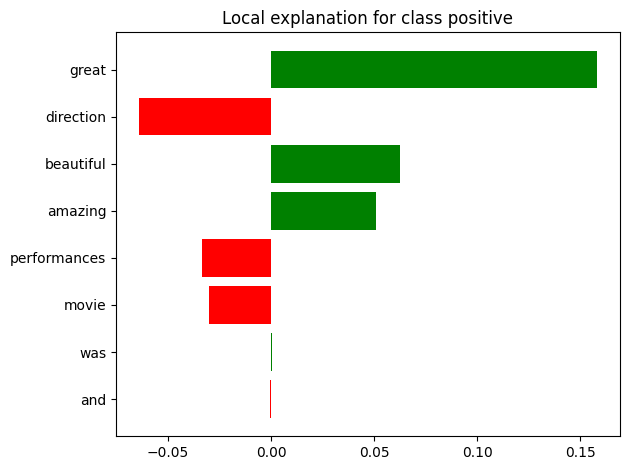

In [33]:

def explain_with_lime(text, num_features=8, num_samples=2000, random_state=42):
    if not HAS_LIME:
        print("LIME is not installed. Run: pip install lime")
        return None

    explainer = LimeTextExplainer(class_names=class_names, random_state=random_state)
    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=pipeline.predict_proba,
        num_features=num_features,
        num_samples=num_samples,
        top_labels=1
    )

    pred_idx = int(np.argmax(pipeline.predict_proba([text])[0]))
    pred_label = class_names[pred_idx]
    print("LIME explanation for predicted class:", pred_label)
    print(exp.as_list(label=pred_idx))

    fig = exp.as_pyplot_figure(label=pred_idx)
    plt.tight_layout()
    plt.show()
    return exp

lime_exp = explain_with_lime(sample_text)


Top SHAP contributions (features present in the text):


,feature,tfidf,shap_value
0,great,0.331558,0.534529
1,beautiful,0.431219,0.292442
2,amazing,0.431219,0.259158
3,direction,0.494931,-0.138785
4,movie,0.212845,-0.080191
5,performances,0.477399,-0.010829


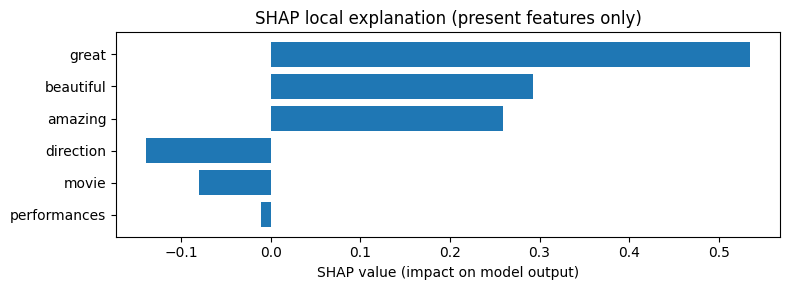

In [34]:

def explain_with_shap_linear(text, top_k=10):
    if not HAS_SHAP:
        print("SHAP is not installed. Run: pip install shap")
        return None

    vectorizer = pipeline.named_steps["tfidf"]
    clf = pipeline.named_steps["clf"]

    X_train_tfidf = vectorizer.transform(X_train)
    x_instance = vectorizer.transform([text])
    feature_names = vectorizer.get_feature_names_out()

    # SHAP API compatibility across versions
    try:
        explainer = shap.LinearExplainer(clf, X_train_tfidf)
        shap_values = explainer.shap_values(x_instance)
    except Exception:
        # fallback for some versions
        masker = shap.maskers.Independent(X_train_tfidf)
        explainer = shap.Explainer(clf, masker)
        shap_values = explainer(x_instance)

    # Normalize outputs across SHAP versions
    if hasattr(shap_values, "values"):  # new API returns Explanation
        vals = shap_values.values
        # binary logistic can be shape (1, n_features) or (1, n_features, n_classes)
        if vals.ndim == 3:
            pred_idx = int(np.argmax(pipeline.predict_proba([text])[0]))
            sv = vals[0, :, pred_idx]
        else:
            sv = vals[0]
    else:
        # older API often returns list for classes or array
        if isinstance(shap_values, list):
            pred_idx = int(np.argmax(pipeline.predict_proba([text])[0]))
            sv = np.array(shap_values[pred_idx]).reshape(-1)
        else:
            sv = np.array(shap_values).reshape(-1)

    x_dense = x_instance.toarray()[0]
    present_idx = np.where(x_dense > 0)[0]
    if len(present_idx) == 0:
        print("No non-zero TF-IDF features found for this text.")
        return None

    top_present = present_idx[np.argsort(np.abs(sv[present_idx]))[::-1][:top_k]]
    out = pd.DataFrame({
        "feature": feature_names[top_present],
        "tfidf": x_dense[top_present],
        "shap_value": sv[top_present]
    }).sort_values("shap_value", key=np.abs, ascending=False)

    print("Top SHAP contributions (features present in the text):")
    display(out)

    # Simple bar chart
    out_plot = out.iloc[::-1]
    plt.figure(figsize=(8, max(3, 0.4*len(out_plot))))
    plt.barh(out_plot["feature"], out_plot["shap_value"])
    plt.xlabel("SHAP value (impact on model output)")
    plt.title("SHAP local explanation (present features only)")
    plt.tight_layout()
    plt.show()
    return out

shap_out = explain_with_shap_linear(sample_text, top_k=10)


In [35]:

def show_top_coefficients(top_k=15):
    vectorizer = pipeline.named_steps["tfidf"]
    clf = pipeline.named_steps["clf"]
    feature_names = vectorizer.get_feature_names_out()

    # Binary classification: coef_[0] corresponds to the positive class in classes_[1]
    coef = clf.coef_[0]
    classes = clf.classes_
    pos_class = classes[1]
    neg_class = classes[0]

    top_pos_idx = np.argsort(coef)[-top_k:][::-1]
    top_neg_idx = np.argsort(coef)[:top_k]

    pos_df = pd.DataFrame({"feature": feature_names[top_pos_idx], "coefficient": coef[top_pos_idx]})
    neg_df = pd.DataFrame({"feature": feature_names[top_neg_idx], "coefficient": coef[top_neg_idx]})

    print(f"Top words pushing toward class: {pos_class}")
    display(pos_df)
    print(f"Top words pushing toward class: {neg_class}")
    display(neg_df)

    return pos_df, neg_df

coef_pos, coef_neg = show_top_coefficients(top_k=10)


Top words pushing toward class: 1


,feature,coefficient
0,great,1.657467
1,love,1.126459
2,funny,1.073828
3,liked,1.040554
4,wonderful,1.000900
5,enjoyed,0.998248
6,excellent,0.957855
7,10,0.955826
8,cast,0.837670
9,loved,0.805573


Top words pushing toward class: 0


,feature,coefficient
0,bad,-2.375134
1,plot,-1.419926
2,awful,-1.281026
3,just,-0.970084
4,boring,-0.931181
5,worst,-0.881972
6,script,-0.875836
7,waste time,-0.815452
8,terrible,-0.813874
9,sucked,-0.786927


In [36]:

def show_eli5_weights(top=20):
    if not HAS_ELI5:
        print("ELI5 is not installed. Run: pip install eli5")
        return None

    # ELI5 works well directly on the linear classifier + vectorizer
    vec = pipeline.named_steps["tfidf"]
    clf = pipeline.named_steps["clf"]

    html = eli5.show_weights(
        clf,
        vec=vec,
        top=top,
        target_names=list(clf.classes_)
    )
    return html

eli5_html = show_eli5_weights(top=15)
eli5_html



Text: Amazing acting and a touching story, I loved it
Predicted class: positive (1)
Probabilities: {'negative': 0.3713, 'positive': 0.6287}
LIME explanation for predicted class: positive
[(np.str_('loved'), 0.10660691692147863), (np.str_('Amazing'), 0.07623047528836713), (np.str_('acting'), -0.06365751848141765), (np.str_('story'), -0.03848578648033266), (np.str_('touching'), 0.020914445545595215), (np.str_('I'), 0.001056320965664193)]


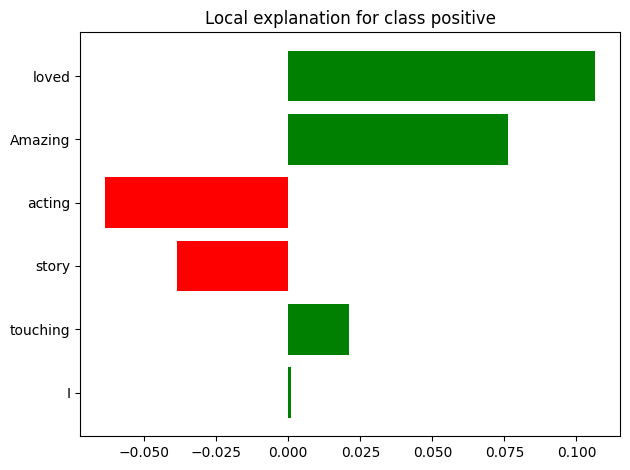

Top SHAP contributions (features present in the text):


,feature,tfidf,shap_value
0,loved,0.462466,0.370607
1,amazing,0.471517,0.283377
2,acting,0.347779,-0.171413
3,touching,0.541183,0.124948
4,story,0.387256,-0.089405


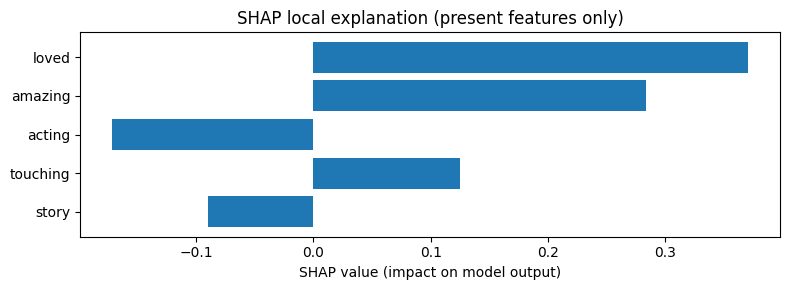


Text: Boring movie with terrible pacing and weak script
Predicted class: negative (0)
Probabilities: {'negative': 0.7735, 'positive': 0.2265}
LIME explanation for predicted class: negative
[(np.str_('Boring'), 0.07057395238411088), (np.str_('script'), 0.06069509340551934), (np.str_('terrible'), 0.05230941496987597), (np.str_('pacing'), -0.03378468445470158), (np.str_('movie'), 0.008672249277481534), (np.str_('weak'), 0.0023688062089930297)]


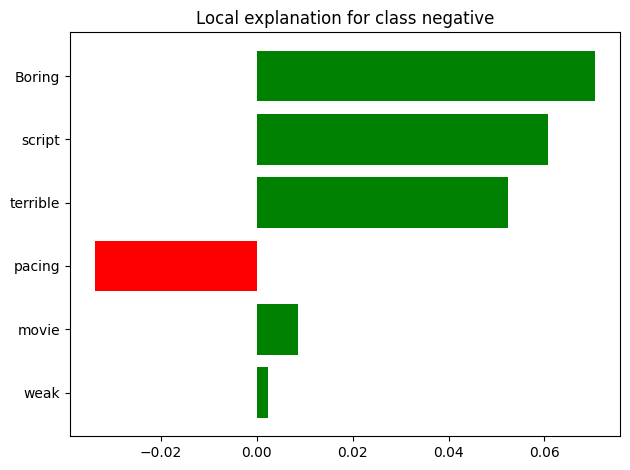

Top SHAP contributions (features present in the text):


,feature,tfidf,shap_value
0,boring,0.365658,-0.338289
1,script,0.327327,-0.286685
2,terrible,0.341160,-0.271479
3,weak,0.419683,-0.124863
4,movie terrible,0.465861,-0.114797
5,movie,0.180485,-0.067434
6,pacing,0.465861,-0.021993


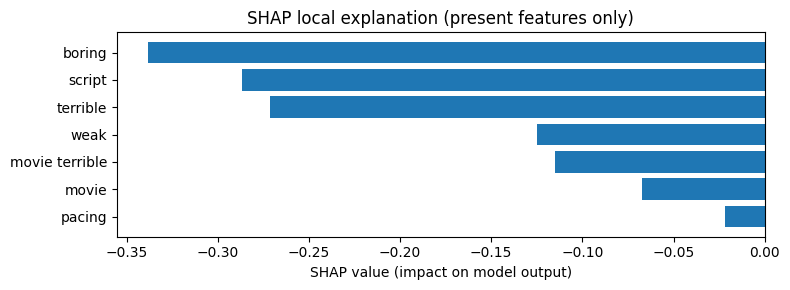


Text: Great visuals but the plot was dull and predictable
Predicted class: negative (0)
Probabilities: {'negative': 0.5312, 'positive': 0.4688}
LIME explanation for predicted class: negative
[(np.str_('Great'), -0.21000203272873164), (np.str_('plot'), 0.18680088808611345), (np.str_('dull'), 0.031613217302883884), (np.str_('predictable'), 0.0202924307608904), (np.str_('visuals'), 0.002078978055871067), (np.str_('but'), -0.001298964231710231)]


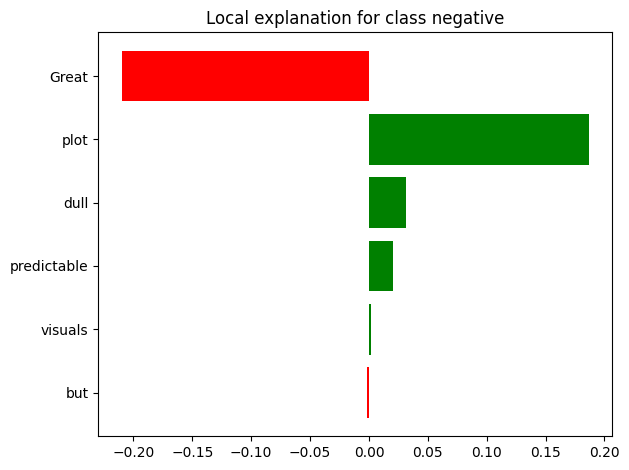

Top SHAP contributions (features present in the text):


,feature,tfidf,shap_value
0,great,0.400052,0.648055
1,plot,0.423453,-0.595334
2,dull,0.624446,-0.119898
3,predictable,0.520302,-0.075204


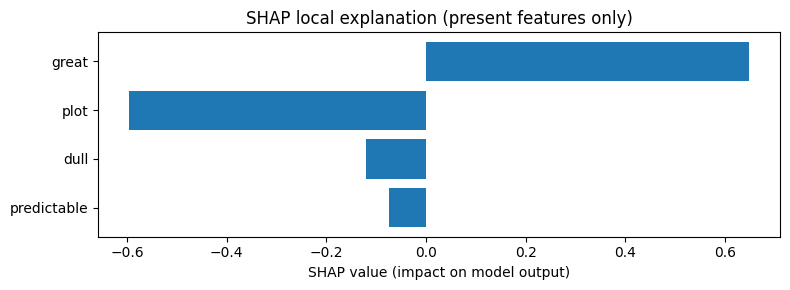

In [37]:

test_sentences = [
    "Amazing acting and a touching story, I loved it",
    "Boring movie with terrible pacing and weak script",
    "Great visuals but the plot was dull and predictable"
]

for txt in test_sentences:
    print("\n" + "="*100)
    predict_and_show(txt)
    if HAS_LIME:
        _ = explain_with_lime(txt, num_features=6, num_samples=1500, random_state=RANDOM_STATE)
    if HAS_SHAP:
        _ = explain_with_shap_linear(txt, top_k=8)



RL for Human-in-the-Loop Triage (Contextual Bandit)

This section adds a **cost-aware triage policy** on top of the sentiment classifier.  
For each text, the agent chooses one action:

- **auto_accept**: trust the model prediction
- **human_review**: send to a (simulated) human reviewer
- **retrain_queue**: abstain and queue for later retraining/inspection

### State (context features)
We build a state vector from:
- prediction confidence / margin / entropy
- **LIME–SHAP disagreement** (if available; otherwise a proxy)
- text length
- simple OOD proxy (distance from training centroid in TF-IDF space)
- user type and runtime budget (simulated metadata)

### Reward
A cost-aware reward balances correctness and operational costs:
- accuracy gain
- review cost
- delay penalty
- stronger penalty for wrong auto-accepts



In [41]:

from dataclasses import dataclass
from collections import Counter
import time

ACTION_NAMES = ["auto_accept", "human_review", "retrain_queue"]
USER_TYPES = ["casual", "analyst", "safety_critical"]


try:
    vectorizer = pipeline.named_steps["tfidf"]
except Exception:
    vectorizer = list(pipeline.named_steps.values())[0]

try:
    clf = pipeline.named_steps["clf"]
except Exception:
    clf = list(pipeline.named_steps.values())[-1]

feature_names = np.array(vectorizer.get_feature_names_out())
coef_vec = clf.coef_[0]

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

train_centroid = np.asarray(X_train_tfidf.mean(axis=0)).ravel()
centroid_norm = np.linalg.norm(train_centroid) + 1e-12

def _tokenize_simple(text):
    try:
        analyzer = vectorizer.build_analyzer()
        return analyzer(text)
    except Exception:
        return str(text).lower().split()

def _proba_stats(text):
    p = pipeline.predict_proba([text])[0]
    p = np.asarray(p, dtype=float)
    p_sorted = np.sort(p)
    confidence = float(p_sorted[-1])
    margin = float(p_sorted[-1] - p_sorted[-2]) if p.size >= 2 else float(p_sorted[-1])
    entropy = float(-(p * np.log(p + 1e-12)).sum())
    pred = int(np.argmax(p))
    return p, pred, confidence, margin, entropy

def _coef_top_tokens(text, top_k=8):
    x = vectorizer.transform([text])
    row = x.toarray().ravel()
    nz = np.where(row != 0)[0]
    if len(nz) == 0:
        return [], {}
    contrib = row[nz] * coef_vec[nz]
    order = np.argsort(np.abs(contrib))[::-1][:top_k]
    idxs = nz[order]
    tokens = [str(feature_names[i]) for i in idxs]
    signed = {str(feature_names[i]): float(np.sign(row[i] * coef_vec[i])) for i in idxs}
    return tokens, signed

def _lime_top_tokens(text, top_k=8):
    if not globals().get("HAS_LIME", False):
        return [], {}, None
    start = time.perf_counter()
    try:
        explainer = LimeTextExplainer(class_names=class_names, random_state=42)
        exp = explainer.explain_instance(
            text, pipeline.predict_proba, num_features=top_k, num_samples=1000, top_labels=1
        )
        label = exp.top_labels[0]
        pairs = exp.as_list(label=label)
        tokens, signed = [], {}
        for feat, w in pairs:
            token = str(feat).split(" ")[0].replace("'", "").strip()
            if token:
                tokens.append(token)
                signed[token] = float(np.sign(w))
        elapsed = time.perf_counter() - start
        return tokens[:top_k], signed, elapsed
    except Exception:
        return [], {}, None

def _shap_top_tokens(text, top_k=8):

    start = time.perf_counter()
    try:
        x = vectorizer.transform([text]).toarray().ravel()
        nz = np.where(x != 0)[0]
        if len(nz) == 0:
            return [], {}, time.perf_counter() - start
        vals = x[nz] * coef_vec[nz]
        order = np.argsort(np.abs(vals))[::-1][:top_k]
        idxs = nz[order]
        tokens = [str(feature_names[i]) for i in idxs]
        signed = {str(feature_names[i]): float(np.sign(x[i] * coef_vec[i])) for i in idxs}
        return tokens, signed, time.perf_counter() - start
    except Exception:
        return [], {}, None

def _disagreement_lime_shap(text, top_k=8):
    lime_tokens, lime_signs, lime_t = _lime_top_tokens(text, top_k=top_k)
    shap_tokens, shap_signs, shap_t = _shap_top_tokens(text, top_k=top_k)

    if len(shap_tokens) == 0 and len(lime_tokens) == 0:
        return 0.5, {"jaccard": 0.0, "sign_disagreement": 0.0, "lime_time": lime_t, "shap_time": shap_t, "mode":"none"}
    if len(lime_tokens) == 0:
        _, pred, conf, margin, ent = _proba_stats(text)
        proxy = float(np.clip(1.0 - margin, 0, 1))
        return proxy, {"jaccard": np.nan, "sign_disagreement": np.nan, "lime_time": lime_t, "shap_time": shap_t, "mode":"proxy_no_lime"}
    if len(shap_tokens) == 0:
        _, pred, conf, margin, ent = _proba_stats(text)
        proxy = float(np.clip(1.0 - margin, 0, 1))
        return proxy, {"jaccard": np.nan, "sign_disagreement": np.nan, "lime_time": lime_t, "shap_time": shap_t, "mode":"proxy_no_shap"}

    set_l, set_s = set(lime_tokens), set(shap_tokens)
    inter = set_l & set_s
    union = set_l | set_s
    jaccard = len(inter) / max(len(union), 1)

    shared = [tok for tok in inter if tok in lime_signs and tok in shap_signs]
    if len(shared) == 0:
        sign_dis = 1.0
    else:
        same = sum(1 for tok in shared if lime_signs[tok] == shap_signs[tok])
        sign_dis = 1.0 - (same / len(shared))

    disagreement = float(np.clip(0.6 * (1 - jaccard) + 0.4 * sign_dis, 0, 1))
    return disagreement, {"jaccard": jaccard, "sign_disagreement": sign_dis, "lime_time": lime_t, "shap_time": shap_t, "mode":"measured"}

def _ood_proxy(text):
    x = vectorizer.transform([text]).toarray().ravel()
    x_norm = np.linalg.norm(x) + 1e-12
    cos_sim = float(np.dot(x, train_centroid) / (x_norm * centroid_norm))
    l2_dist = float(np.linalg.norm(x - train_centroid))
    ood = float(np.clip((1 - cos_sim), 0, 1))
    return ood, cos_sim, l2_dist

def build_state_features(text, user_type="casual", runtime_budget="medium"):
    probs, pred, conf, margin, ent = _proba_stats(text)
    length_words = len(_tokenize_simple(text))
    length_chars = len(str(text))
    disagreement, dis_meta = _disagreement_lime_shap(text, top_k=8)
    ood, cos_sim, l2_dist = _ood_proxy(text)

    budget_levels = ["low", "medium", "high"]
    budget_vec = [1.0 if runtime_budget == b else 0.0 for b in budget_levels]

    user_vec = [1.0 if user_type == u else 0.0 for u in USER_TYPES]

    model_type_vec = [1.0]

    state = np.array([
        conf,
        margin,
        ent,
        disagreement,
        min(length_words / 50.0, 1.0),
        min(length_chars / 300.0, 1.0),
        ood,
        float(cos_sim),
        float(np.clip(l2_dist / 5.0, 0, 1)),
        *budget_vec,
        *user_vec,
        *model_type_vec
    ], dtype=float)

    meta = {
        "pred": pred,
        "probs": probs,
        "confidence": conf,
        "margin": margin,
        "entropy": ent,
        "disagreement": disagreement,
        "disagreement_meta": dis_meta,
        "length_words": length_words,
        "length_chars": length_chars,
        "ood_score": ood,
        "cos_sim_centroid": cos_sim,
        "l2_dist_centroid": l2_dist,
        "user_type": user_type,
        "runtime_budget": runtime_budget,
    }
    return state, meta

@dataclass
class TriageRewardConfig:
    wrong_auto_penalty: float = 2.0
    review_cost: float = 0.35
    delay_penalty: float = 0.20
    retrain_ood_bonus: float = 0.35
    human_accuracy: float = 1.0  # set <1.0 to simulate reviewer mistakes
    abstain_low_conf_bonus: float = 0.15

reward_cfg = TriageRewardConfig()

def simulate_triage_outcome(true_label, action, state_meta, reward_cfg=reward_cfg, rng=None):
    """
    action:
      0 -> auto_accept
      1 -> human_review
      2 -> retrain_queue
    """
    if rng is None:
        rng = np.random.default_rng(42)

    model_pred = int(state_meta["pred"])
    conf = float(state_meta["confidence"])
    ood = float(state_meta["ood_score"])
    is_correct = int(model_pred == int(true_label))

    if action == 0:  # auto_accept
        final_pred = model_pred
        if is_correct:
            reward = 1.0
        else:
            reward = -float(reward_cfg.wrong_auto_penalty)
        info = {"final_correct": int(final_pred == int(true_label)), "final_pred": final_pred, "route": "auto_accept"}

    elif action == 1:
        human_correct = 1 if rng.random() < reward_cfg.human_accuracy else 0
        final_pred = int(true_label) if human_correct else 1 - int(true_label)
        reward = (1.0 if human_correct else -1.0) - float(reward_cfg.review_cost)
        info = {"final_correct": int(final_pred == int(true_label)), "final_pred": final_pred, "route": "human_review"}

    elif action == 2:
        reward = -float(reward_cfg.delay_penalty)
        if ood > 0.6:
            reward += float(reward_cfg.retrain_ood_bonus)
        if conf < 0.65:
            reward += float(reward_cfg.abstain_low_conf_bonus)
        final_pred = None
        info = {"final_correct": None, "final_pred": final_pred, "route": "retrain_queue"}

    else:
        raise ValueError("Unknown action")

    info["reward"] = float(reward)
    info["model_pred_correct"] = is_correct
    return float(reward), info

print("RL triage feature / reward setup ready.")
print("State dimension example:", build_state_features(X_test.iloc[0] if hasattr(X_test, "iloc") else X_test[0])[0].shape[0])


RL triage feature / reward setup ready.
State dimension example: 16


In [42]:


rng = np.random.default_rng(123)

if hasattr(X_test, "reset_index"):
    X_test_arr = X_test.reset_index(drop=True)
else:
    X_test_arr = pd.Series(list(X_test))
if hasattr(y_test, "reset_index"):
    y_test_arr = y_test.reset_index(drop=True)
else:
    y_test_arr = pd.Series(list(y_test))

runtime_budgets = ["low", "medium", "high"]
budget_probs = [0.4, 0.4, 0.2]
user_probs = [0.45, 0.35, 0.20]  # casual, analyst, safety_critical

contexts = []
context_meta = []
for i in range(len(X_test_arr)):
    txt = str(X_test_arr.iloc[i])
    y_true = int(y_test_arr.iloc[i])

    user_type = rng.choice(USER_TYPES, p=user_probs)
    runtime_budget = rng.choice(runtime_budgets, p=budget_probs)

    s, meta = build_state_features(txt, user_type=user_type, runtime_budget=runtime_budget)
    meta["text"] = txt
    meta["y_true"] = y_true
    contexts.append(s)
    context_meta.append(meta)

X_ctx = np.vstack(contexts)
n_rounds, d = X_ctx.shape
n_actions = len(ACTION_NAMES)

def oracle_action(meta, reward_cfg=reward_cfg):
    rewards = []
    for a in range(n_actions):
        r, _ = simulate_triage_outcome(meta["y_true"], a, meta, reward_cfg=reward_cfg, rng=np.random.default_rng(999))
        rewards.append(r)
    best_a = int(np.argmax(rewards))
    return best_a, rewards

def random_policy(meta, rng):
    return int(rng.integers(0, n_actions))

def heuristic_policy(meta):

    conf = meta["confidence"]
    dis = meta["disagreement"]
    ood = meta["ood_score"]
    user_type = meta["user_type"]

    if ood > 0.75:
        return 2  # retrain_queue
    if user_type == "safety_critical" and conf < 0.90:
        return 1  # human_review
    if dis > 0.70 or conf < 0.60:
        return 1
    if conf > 0.86 and dis < 0.45:
        return 0
    return 1

class LinUCBRouter:
    def __init__(self, n_actions, d, alpha=0.9):
        self.n_actions = n_actions
        self.d = d
        self.alpha = alpha
        self.A = [np.eye(d) for _ in range(n_actions)]
        self.b = [np.zeros(d) for _ in range(n_actions)]

    def select_action(self, x):
        x = np.asarray(x, dtype=float)
        p_vals = []
        for a in range(self.n_actions):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv @ self.b[a]
            exploit = theta @ x
            explore = self.alpha * np.sqrt(x @ A_inv @ x)
            p_vals.append(float(exploit + explore))
        return int(np.argmax(p_vals)), p_vals

    def update(self, a, x, reward):
        x = np.asarray(x, dtype=float)
        self.A[a] += np.outer(x, x)
        self.b[a] += reward * x

def evaluate_policy(policy_name="linucb", alpha=0.9, seed=7):
    rng_local = np.random.default_rng(seed)
    linucb = LinUCBRouter(n_actions=n_actions, d=d, alpha=alpha)

    rows = []
    cum_reward = 0.0
    cum_oracle = 0.0

    for t in range(n_rounds):
        x = X_ctx[t]
        meta = context_meta[t]

        if policy_name == "linucb":
            a, scores = linucb.select_action(x)
        elif policy_name == "random":
            a = random_policy(meta, rng_local)
            scores = None
        elif policy_name == "heuristic":
            a = heuristic_policy(meta)
            scores = None
        else:
            raise ValueError("Unknown policy")

        reward, info = simulate_triage_outcome(meta["y_true"], a, meta, reward_cfg=reward_cfg, rng=rng_local)

        # Oracle best reward for this context (simulated with deterministic helper seed for comparability)
        a_star, r_list = oracle_action(meta)
        oracle_r = float(np.max(r_list))

        if policy_name == "linucb":
            linucb.update(a, x, reward)

        cum_reward += reward
        cum_oracle += oracle_r

        rows.append({
            "round": t + 1,
            "policy": policy_name,
            "action": ACTION_NAMES[a],
            "reward": reward,
            "cum_reward": cum_reward,
            "oracle_reward": oracle_r,
            "cum_oracle_reward": cum_oracle,
            "instant_regret": oracle_r - reward,
            "cum_regret": cum_oracle - cum_reward,
            "confidence": meta["confidence"],
            "margin": meta["margin"],
            "disagreement": meta["disagreement"],
            "ood_score": meta["ood_score"],
            "user_type": meta["user_type"],
            "runtime_budget": meta["runtime_budget"],
            "y_true": meta["y_true"],
            "model_pred": meta["pred"],
            "model_pred_correct": info["model_pred_correct"],
            "final_correct": info["final_correct"],
            "route": info["route"],
        })

    return pd.DataFrame(rows)

# Run evaluations
df_linucb = evaluate_policy("linucb", alpha=0.9, seed=11)
df_rand = evaluate_policy("random", seed=11)
df_heur = evaluate_policy("heuristic", seed=11)

def summarize_policy(df):
    out = {
        "avg_reward": df["reward"].mean(),
        "total_reward": df["reward"].sum(),
        "avg_regret": df["instant_regret"].mean(),
        "final_cum_regret": df["cum_regret"].iloc[-1],
        "auto_accept_rate": (df["action"] == "auto_accept").mean(),
        "human_review_rate": (df["action"] == "human_review").mean(),
        "retrain_queue_rate": (df["action"] == "retrain_queue").mean(),
        "wrong_auto_accept_rate": ((df["action"] == "auto_accept") & (df["model_pred_correct"] == 0)).mean(),
        "post_triage_accuracy_on_decided": df.loc[df["final_correct"].notna(), "final_correct"].mean() if df["final_correct"].notna().any() else np.nan,
        "coverage_decided": df["final_correct"].notna().mean(),
    }
    return pd.Series(out)

summary_df = pd.concat({
    "linucb": summarize_policy(df_linucb),
    "heuristic": summarize_policy(df_heur),
    "random": summarize_policy(df_rand)
}, axis=1).T

print("Policy summary (higher avg_reward / lower regret is better):")
display(summary_df.round(4))


Policy summary (higher avg_reward / lower regret is better):


,avg_reward,total_reward,avg_regret,final_cum_regret,auto_accept_rate,human_review_rate,retrain_queue_rate,wrong_auto_accept_rate,post_triage_accuracy_on_decided,coverage_decided
linucb,0.6098,121.95,0.3220,64.40,0.195,0.720,0.085,0.025,0.9727,0.915
heuristic,0.2667,53.35,0.6650,133.00,0.000,0.010,0.990,0.000,1.0000,0.010
random,0.3965,79.30,0.5352,107.05,0.360,0.325,0.315,0.085,0.8759,0.685


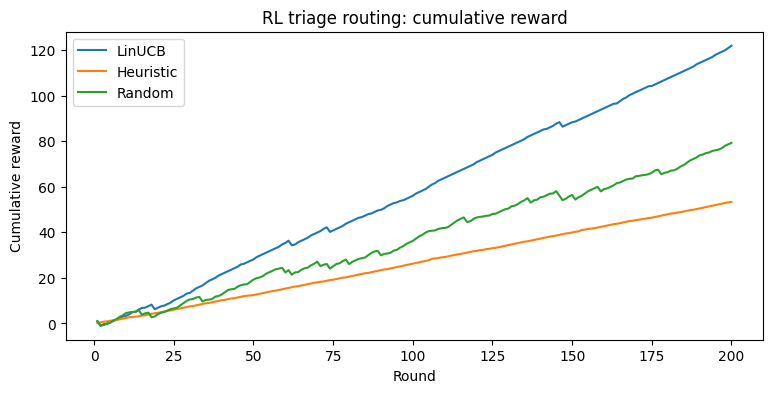

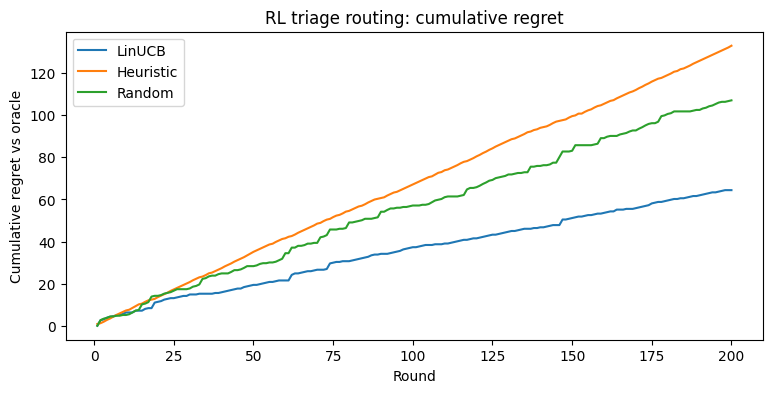

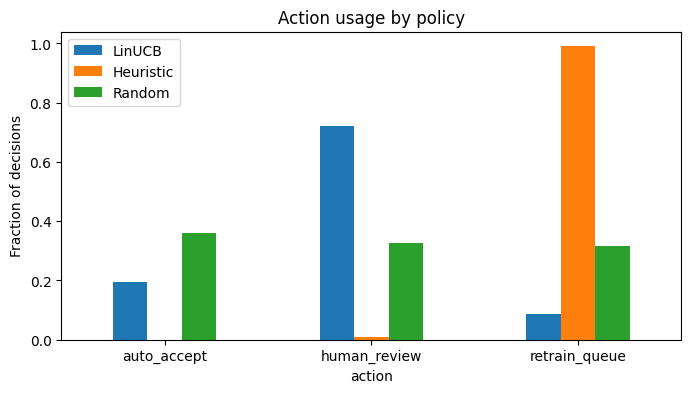

/tmp/ipython-input-4234662882.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby(f"{col}_bin").agg(
/tmp/ipython-input-4234662882.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in tmp.groupby(f"{col}_bin"):


,avg_reward,auto_accept_rate,human_review_rate,retrain_queue_rate,wrong_auto_accept_rate
confidence_bin,,,,,
"(0.499, 0.539]",0.544,0.16,0.72,0.12,NaN
"(0.539, 0.583]",0.611,0.08,0.90,0.02,NaN
"(0.583, 0.647]",0.579,0.24,0.66,0.10,NaN
"(0.647, 0.887]",0.705,0.30,0.60,0.10,NaN


/tmp/ipython-input-4234662882.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby(f"{col}_bin").agg(
/tmp/ipython-input-4234662882.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in tmp.groupby(f"{col}_bin"):


,avg_reward,auto_accept_rate,human_review_rate,retrain_queue_rate,wrong_auto_accept_rate
disagreement_bin,,,,,
"(-0.001, 0.36]",0.657,0.250,0.692,0.058,NaN
"(0.36, 0.525]",0.589,0.265,0.653,0.082,NaN
"(0.525, 0.729]",0.650,0.245,0.694,0.061,NaN
"(0.729, 1.0]",0.542,0.020,0.840,0.140,NaN


/tmp/ipython-input-4234662882.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby(f"{col}_bin").agg(
/tmp/ipython-input-4234662882.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in tmp.groupby(f"{col}_bin"):


,avg_reward,auto_accept_rate,human_review_rate,retrain_queue_rate,wrong_auto_accept_rate
ood_score_bin,,,,,
"(0.642, 0.882]",0.563,0.20,0.72,0.08,NaN
"(0.882, 0.927]",0.653,0.24,0.70,0.06,NaN
"(0.927, 0.956]",0.573,0.24,0.66,0.10,NaN
"(0.956, 1.0]",0.650,0.10,0.80,0.10,NaN


Case studies (LinUCB decisions):
------------------------------------------------------------------------------------------
Round 2 | action=auto_accept | reward=-2.00 | user=casual | budget=low
  confidence=0.588, margin=0.177, disagreement=0.400, ood=0.889
  model_pred=positive, true=negative
  text: but the movie makes a lot of serious mistakes.
------------------------------------------------------------------------------------------
Round 19 | action=auto_accept | reward=-2.00 | user=analyst | budget=high
  confidence=0.512, margin=0.025, disagreement=0.700, ood=0.956
  model_pred=negative, true=positive
  text: It's quite simply the highest, most superlative form of cinema imaginable.
------------------------------------------------------------------------------------------
Round 62 | action=auto_accept | reward=-2.00 | user=analyst | budget=medium
  confidence=0.597, margin=0.195, disagreement=0.400, ood=0.837
  model_pred=negative, true=positive
  text: You share General Loewen

In [40]:

# --- Visualizations + case studies for RL triage ---
import matplotlib.pyplot as plt

# Learning curves
plt.figure(figsize=(9, 4))
plt.plot(df_linucb["round"], df_linucb["cum_reward"], label="LinUCB")
plt.plot(df_heur["round"], df_heur["cum_reward"], label="Heuristic")
plt.plot(df_rand["round"], df_rand["cum_reward"], label="Random")
plt.xlabel("Round")
plt.ylabel("Cumulative reward")
plt.title("RL triage routing: cumulative reward")
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(df_linucb["round"], df_linucb["cum_regret"], label="LinUCB")
plt.plot(df_heur["round"], df_heur["cum_regret"], label="Heuristic")
plt.plot(df_rand["round"], df_rand["cum_regret"], label="Random")
plt.xlabel("Round")
plt.ylabel("Cumulative regret vs oracle")
plt.title("RL triage routing: cumulative regret")
plt.legend()
plt.show()

# Action distribution
fig, ax = plt.subplots(figsize=(8,4))
action_counts = pd.DataFrame({
    "LinUCB": df_linucb["action"].value_counts(normalize=True),
    "Heuristic": df_heur["action"].value_counts(normalize=True),
    "Random": df_rand["action"].value_counts(normalize=True),
}).fillna(0).loc[ACTION_NAMES]
action_counts.plot(kind="bar", ax=ax)
ax.set_ylabel("Fraction of decisions")
ax.set_title("Action usage by policy")
plt.xticks(rotation=0)
plt.show()

# Slice analysis: where triage matters
slice_cols = ["confidence", "disagreement", "ood_score"]
for col in slice_cols:
    bins = pd.qcut(df_linucb[col], q=min(4, len(df_linucb[col].unique())), duplicates="drop")
    tmp = df_linucb.copy()
    tmp[f"{col}_bin"] = bins
    agg = tmp.groupby(f"{col}_bin").agg(
        avg_reward=("reward","mean"),
        auto_accept_rate=("action", lambda s: (s=="auto_accept").mean()),
        human_review_rate=("action", lambda s: (s=="human_review").mean()),
        retrain_queue_rate=("action", lambda s: (s=="retrain_queue").mean()),
        wrong_auto_accept_rate=("model_pred_correct", lambda s: np.nan),  # placeholder
    )
    # Compute wrong auto-accept by bin
    wrong_rates = []
    for b, g in tmp.groupby(f"{col}_bin"):
        wrong = ((g["action"]=="auto_accept") & (g["model_pred_correct"]==0)).mean()
        wrong_rates.append((b, wrong))
    wr = pd.Series({str(k):v for k,v in wrong_rates})
    display(agg.round(3))

# Show a few interesting examples chosen by LinUCB
interesting = pd.concat([
    df_linucb.sort_values("reward").head(3),      # bad outcomes
    df_linucb.sort_values("disagreement", ascending=False).head(3), # high disagreement
    df_linucb[df_linucb["action"]=="retrain_queue"].head(3)         # abstentions
]).drop_duplicates(subset=["round"]).head(8)

print("Case studies (LinUCB decisions):")
for _, r in interesting.iterrows():
    idx = int(r["round"] - 1)
    meta = context_meta[idx]
    print("-" * 90)
    print(f"Round {int(r['round'])} | action={r['action']} | reward={r['reward']:.2f} | user={r['user_type']} | budget={r['runtime_budget']}")
    print(f"  confidence={r['confidence']:.3f}, margin={r['margin']:.3f}, disagreement={r['disagreement']:.3f}, ood={r['ood_score']:.3f}")
    print(f"  model_pred={class_names[int(meta['pred'])]}, true={class_names[int(meta['y_true'])]}")
    txt = meta["text"]
    print(f"  text: {txt[:180]}{'...' if len(txt)>180 else ''}")

# Optional: demo a single online decision for a new text
def triage_decision_for_text(text, user_type="casual", runtime_budget="medium", alpha=0.9):
    # train a fresh LinUCB quickly on observed test contexts for a reproducible demo
    router = LinUCBRouter(n_actions=n_actions, d=d, alpha=alpha)
    demo_rng = np.random.default_rng(2026)
    for t in range(n_rounds):
        a, _ = router.select_action(X_ctx[t])
        r, _ = simulate_triage_outcome(context_meta[t]["y_true"], a, context_meta[t], reward_cfg=reward_cfg, rng=demo_rng)
        router.update(a, X_ctx[t], r)

    x, meta = build_state_features(text, user_type=user_type, runtime_budget=runtime_budget)
    a, scores = router.select_action(x)
    return {
        "recommended_action": ACTION_NAMES[a],
        "ucb_scores": {ACTION_NAMES[i]: float(scores[i]) for i in range(n_actions)},
        "state_meta": meta,
        "model_prediction": class_names[int(meta["pred"])],
    }

demo_text = "The plot was slow and confusing, but the cinematography was beautiful."
demo_out = triage_decision_for_text(demo_text, user_type="analyst", runtime_budget="low")
print("\nDemo triage decision:")
print(demo_out["recommended_action"])
print({k: round(v, 3) for k, v in demo_out["ucb_scores"].items()})
print({
    "model_prediction": demo_out["model_prediction"],
    "confidence": round(demo_out["state_meta"]["confidence"], 3),
    "margin": round(demo_out["state_meta"]["margin"], 3),
    "disagreement": round(demo_out["state_meta"]["disagreement"], 3),
    "ood_score": round(demo_out["state_meta"]["ood_score"], 3),
    "user_type": demo_out["state_meta"]["user_type"],
    "runtime_budget": demo_out["state_meta"]["runtime_budget"],
})
